<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 2 of 4: Feature Engineering

## Contents:
- [Import Libraries](#Import-Libraries)
- [Define functions](#Define-functions)
- [Import data from Pickle](#Import-data-from-Pickle)
- [Feature Engineering](#Feature-Engineering)
- [Pickle data](#Pickle-data)

# Import Libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import KMeans

import pylab

import lightgbm as lgb

import pickle

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas

# !pip install pipwin
# !pipwin install gdal
# !pipwin install fiona
# !pip install geopandas
# !pipwin install rasterio
# !pip install contextily

In [3]:
# !pip install imblearn

In [4]:
# !pip install lightgbm

## Define functions
- get_weather_data (takes in weather station number, flag, weather feature, lag and return result based on flag)
- add_weather_features (add in numeric weather features to either the train or test data)
- distance (to calculate distance between two coordinates)
- near_station (applied to a dataframe to determine if a location is nearer to Station 1 or 2)

*Back to [Contents](#Contents:)*

In [5]:
def get_weather_data(
        station=1,  # station ID
        flag=1,  # 1: shift, 2: rolling avg, 3: rolling max
        feature=None,
        k=0  # lagged days
):

    # if lagged days == 0, just return the feature data directly
    if k == 0:
        if station == 1:
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
    else:
        if flag == 1:  # shift the feature, and return the result column
            if station == 1:
                return df_weather_1[feature].shift(k).rename(
                    columns={feature[0]: f'{feature[0]}-{k}'})
            else:
                return df_weather_2[feature].shift(k).rename(
                    columns={feature[0]: f'{feature[0]}-{k}'})

        elif flag == 2:  # averge the feature in a rolling period and return the result column
            if station == 1:
                return df_weather_1[feature].rolling(k).mean().rename(
                    columns={feature[0]: f'{feature[0]}-avg-{k}'})
            else:
                return df_weather_2[feature].rolling(k).mean().rename(
                    columns={feature[0]: f'{feature[0]}-avg-{k}'})

        elif flag == 3:  # find the max value of the feature in a rolling period and return the result column
            if station == 1:
                return df_weather_1[feature].rolling(k).max().rename(
                    columns={feature[0]: f'{feature[0]}-max-{k}'})
            else:
                return df_weather_2[feature].rolling(k).max().rename(
                    columns={feature[0]: f'{feature[0]}-max-{k}'})

In [6]:
def add_weather_features(
        df,
        weather_features_shift=None,  #dictionary
        weather_features_avg=None,
        weather_features_max=None):
    df['id_'] = df.index
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")

    features_numeric_weather = [
        "Tmax", "Tmin", "Tavg", 'DewPoint', "Sunrise", "Sunset", 'Day_length',
        'PrecipTotal', 'ResultSpeed'
    ]

    df1 = pd.merge(df1,
                   df_weather_1[features_numeric_weather],
                   on='Date',
                   how='inner')
    df2 = pd.merge(df2,
                   df_weather_2[features_numeric_weather],
                   on='Date',
                   how='inner')

    if weather_features_shift != None:
        for key, value in weather_features_shift.items():
            result_feature_column_1 = get_weather_data(1, 1, [key], value)
            df1 = pd.merge(df1,
                           result_feature_column_1,
                           on='Date',
                           how='inner')

            result_feature_column_2 = get_weather_data(2, 1, [key], value)
            df2 = pd.merge(df2,
                           result_feature_column_2,
                           on='Date',
                           how='inner')

    if weather_features_avg != None:
        for key, value in weather_features_avg.items():
            result_feature_column_1 = get_weather_data(1, 2, [key], value)
            df1 = pd.merge(df1,
                           result_feature_column_1,
                           on='Date',
                           how='inner')

            result_feature_column_2 = get_weather_data(2, 2, [key], value)
            df2 = pd.merge(df2,
                           result_feature_column_2,
                           on='Date',
                           how='inner')

    if weather_features_max != None:
        for key, value in weather_features_max.items():
            result_feature_column_1 = get_weather_data(1, 3, [key], value)
            df1 = pd.merge(df1,
                           result_feature_column_1,
                           on='Date',
                           how='inner')

            result_feature_column_2 = get_weather_data(2, 3, [key], value)
            df2 = pd.merge(df2,
                           result_feature_column_2,
                           on='Date',
                           how='inner')

    df_final = pd.concat([df1, df2], sort=False)
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return df_final

In [7]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

**Reference for distance function above**: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth<br>
(Python 3 program to calculate Distance Between Two Points on Earth)

In [8]:
# the function will find if a location is nearer to Station 1 or 2
# it is to be used in dataframe.apply()


def near_station(row  # a row of record in a dataframe
                 ):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon = -87.933
    station2_lat = 41.786
    station2_lon = -87.752

    if distance(lat, station1_lat, lon, station1_lon) < distance(
            lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

# Import data from Pickle
*Back to [Contents](#Contents:)*

In [9]:
# read pickle_dict, which stores everything from previous notebook

pickle_dict1 = pickle.load(open('../assets/data1.pkl', 'rb'))
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_spray = pickle_dict1['df_spray']
df_weather_1 = pickle_dict1['df_weather_1']
df_weather_2 = pickle_dict1['df_weather_2']

C:\Users\olive\anaconda3\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Feature Engineering
- Species: 
    - All species which do not carry the West Nile Virus will be regrouped to 'OTHERS'
    - Convert the categorical feature of Species into dummy variables
<br>
- Traps:
    - Cluster all traps based on their locations to simplify analysis (we will try with 30 clusters)
    - Convert this categorical feature of Trap Clusters into dummy variables
<br>    
- Weather data
    - To decide on transformation of weather features: whether to shift, apply rolling-mean or rolling-max
    - Once transformation is done, add those weather features to Train set
    
 *Back to [Contents](#Contents:)*

### Feature engineering on Species
- All species which do not carry the West Nile Virus will be regrouped to 'OTHERS'
- Convert the categorical feature of Species into dummy variables

In [10]:
# define a list of mosquito species to keep
species_to_keep = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']

# for Train data
df_train.loc[:,
             ['Species']] = np.where(df_train['Species'].isin(species_to_keep),
                                     df_train['Species'], 'OTHERS')

# for Test submission
df_test.loc[:,
            ['Species']] = np.where(df_test['Species'].isin(species_to_keep),
                                    df_test['Species'], 'OTHERS')

In [11]:
# creating a dataframe just for visualization purposes
# append df_train to df_test to get a total count of mosquitoes
df_visual = df_train.append(df_test)

In [12]:
df_test.Species.value_counts()

OTHERS                    71743
CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
Name: Species, dtype: int64

In [13]:
df_visual = df_visual.groupby(['Species']).size().reset_index(name='counts')
df_visual

,Species,counts
0,CULEX PIPIENS,17220
1,CULEX PIPIENS/RESTUANS,20111
2,CULEX RESTUANS,17410
3,OTHERS,72058


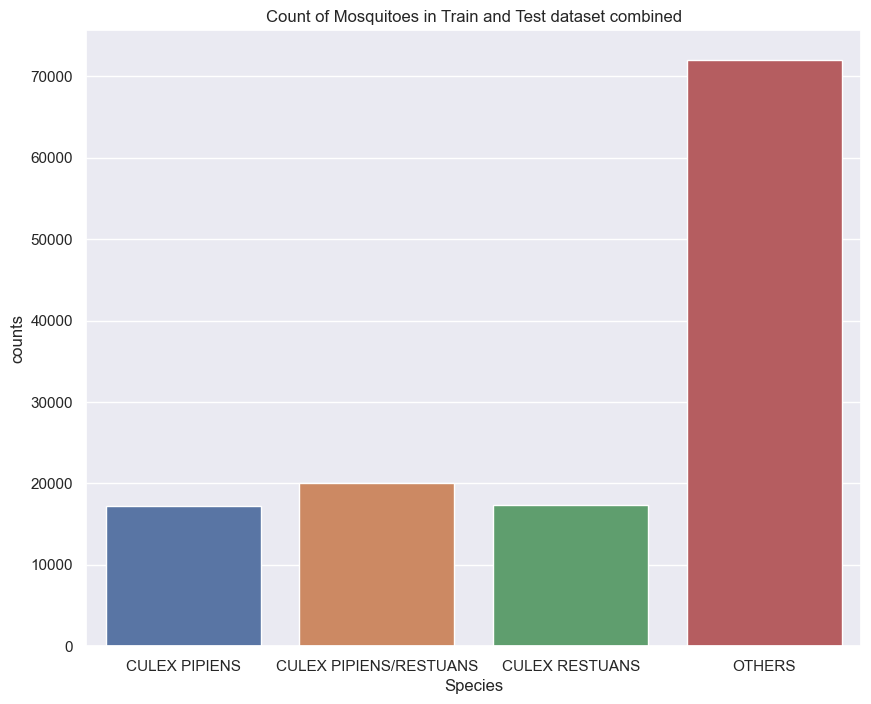

In [14]:
sns.set(rc={'figure.figsize': (10, 8)})
sns.barplot(data=df_visual, x='Species', y='counts').\
set_title('Count of Mosquitoes in Train and Test dataset combined');

In [15]:
#PD get dummy for train and test

# for Train data
df_train = pd.get_dummies(columns=["Species"], data=df_train, drop_first=True)

# for Test submission
df_test = pd.get_dummies(columns=["Species"], data=df_test, drop_first=True)

### Feature engineering on Trap locations
- Cluster all traps based on their locations to simplify analysis (we will try with 30 clusters)
- Convert this categorical feature of Trap Clusters into dummy variables

C:\Users\olive\AppData\Local\Temp\ipykernel_3788\1758574068.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_train, x='Latitude', y='Longitude', palette="muted");


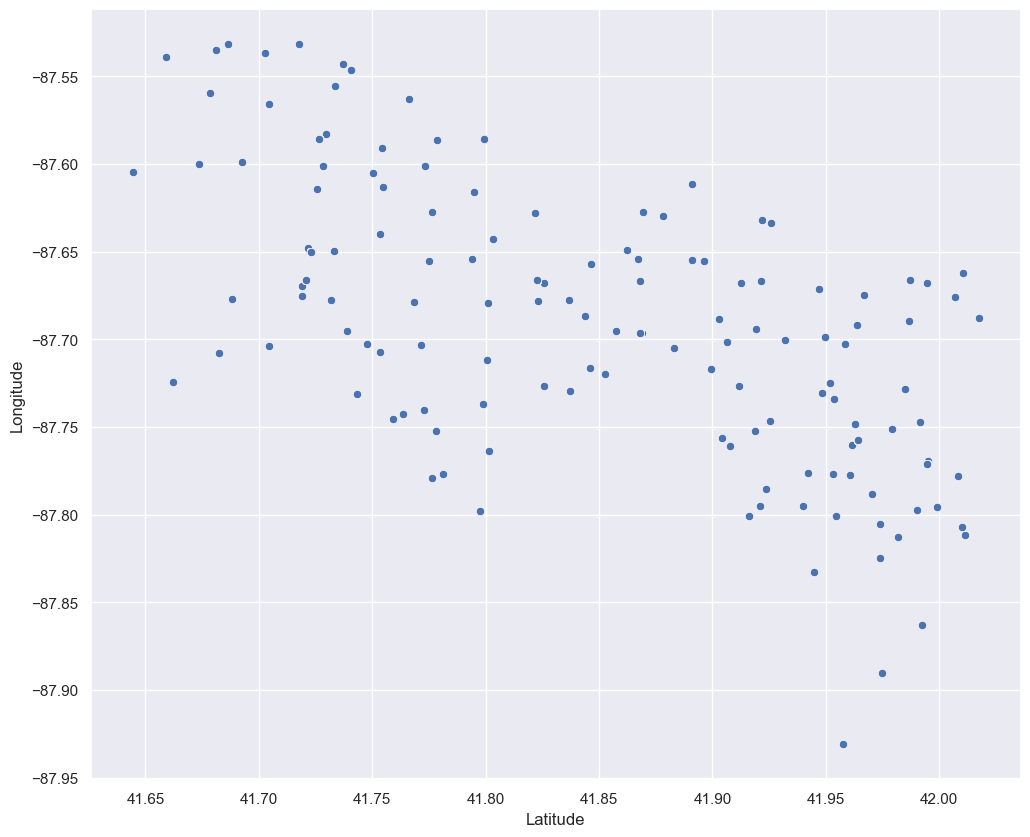

In [16]:
# plot all traps locations
fig, ax = plt.subplots(1, figsize=(12, 10))
sns.scatterplot(data=df_train, x='Latitude', y='Longitude', palette="muted");

In [17]:
# Prepare X matrix
X = df_train.loc[:, ['Latitude', 'Longitude']]

# for Test submission
X_test = df_test.loc[:, ['Latitude', 'Longitude']]

In [18]:
# Instatiate KMeans clustering with 30 clusters
km = KMeans(n_clusters=30, random_state=42)

# Fit our train set to KMeans algorithm
km.fit(X)

KMeans(n_clusters=30, random_state=42)

In [19]:
# Check out the cluster centroids
km.cluster_centers_

array([[ 41.97671976, -87.74650368],
       [ 41.76410356, -87.60413316],
       [ 41.9764036 , -87.88795283],
       [ 41.81609879, -87.6731264 ],
       [ 41.72610751, -87.65870889],
       [ 41.692987  , -87.562828  ],
       [ 41.89336897, -87.654814  ],
       [ 41.91287139, -87.74556978],
       [ 41.78789927, -87.76624012],
       [ 41.95935416, -87.80618051],
       [ 41.99959506, -87.67910765],
       [ 41.662014  , -87.724608  ],
       [ 41.72694528, -87.58945653],
       [ 41.80955606, -87.72762192],
       [ 41.67338941, -87.59995427],
       [ 41.90941666, -87.67818734],
       [ 41.75351024, -87.73693499],
       [ 42.00509324, -87.78956703],
       [ 41.8593489 , -87.701687  ],
       [ 41.91189618, -87.70641409],
       [ 41.76802369, -87.69394015],
       [ 41.92435454, -87.79390506],
       [ 41.957799  , -87.930995  ],
       [ 41.91768068, -87.62919107],
       [ 41.74459434, -87.55102995],
       [ 41.69017459, -87.69846825],
       [ 41.67994474, -87.5360626 ],
 

In [20]:
# store cluster centers into a list
centroid_list = km.cluster_centers_.tolist()

In [21]:
# use the unpacking operator * to unzip the data, creating two different lists
# past the two different lists into a dataframe
df_clusters = pd.DataFrame(list(zip(*centroid_list)))

In [22]:
df_clusters = df_clusters.T

In [23]:
# for Train data
df_train['trap_cluster'] = km.labels_

df_train.head()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry,year,month,week,day,year_month,Station,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,trap_cluster
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,1,0,0,9
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,0,1,0,9
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0,POINT (-87.76928 41.99499),2007,5,22,29,2007-05,1,0,1,0,17
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,1,0,0,9
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,0,1,0,9


In [24]:
# for Test submission
df_test['trap_cluster'] = km.predict(X_test)
df_test.head()

,Id,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,geometry,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,trap_cluster
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),1,0,0,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,1,0,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,0,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,1,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,1,9


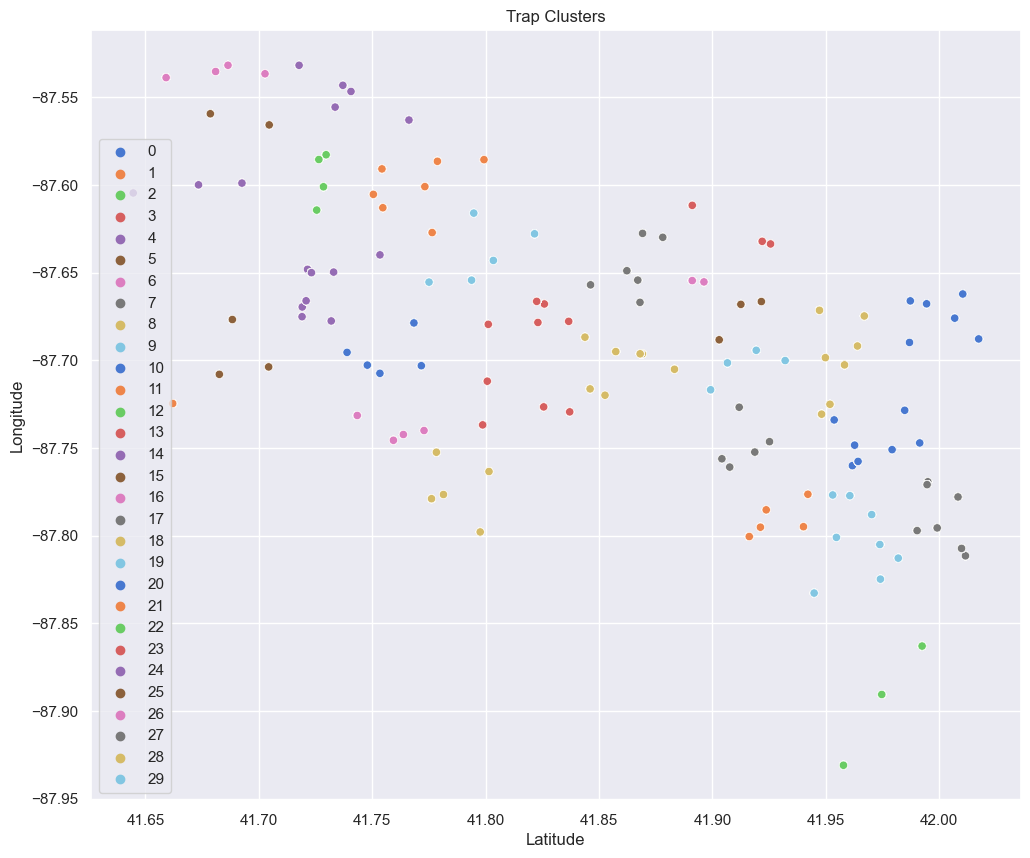

In [25]:
#visualizing Kmean Cluster in train set

fig, ax = plt.subplots(1, figsize=(12, 10))  #setting the figsize like this so that the points can be shown clearly 
sns.scatterplot(data=df_train,
                x='Latitude',
                y='Longitude',
                hue='trap_cluster',
                palette="muted",
                markers={x: x for x in range(30)}).set(title='Trap Clusters')
plt.legend(loc='best');

**Since the algorithm has helped us to decide on the clusters and we are unable to derive further insights from how/why it has been clustered in such a manner, we will proceed to convert the clusters in dummy variables for the next stage.**

In [26]:
# convert trap clusters to dummy variables for Train data
df_train = pd.get_dummies(columns=["trap_cluster"], data=df_train, drop_first=True)

# for Test submission
df_test = pd.get_dummies(columns=["trap_cluster"], data=df_test, drop_first=True)

In [27]:
df_test.head()

,Id,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,geometry,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,trap_cluster_1,trap_cluster_2,trap_cluster_3,trap_cluster_4,trap_cluster_5,trap_cluster_6,trap_cluster_7,trap_cluster_8,trap_cluster_9,trap_cluster_10,trap_cluster_11,trap_cluster_12,trap_cluster_13,trap_cluster_14,trap_cluster_15,trap_cluster_16,trap_cluster_17,trap_cluster_18,trap_cluster_19,trap_cluster_20,trap_cluster_21,trap_cluster_22,trap_cluster_23,trap_cluster_24,trap_cluster_25,trap_cluster_26,trap_cluster_27,trap_cluster_28,trap_cluster_29
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,POINT (-87.80099 41.95469),0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature engineering on Weather data
- Create new column "Station" to indicate which weather station a trap is closer to
- To decide on transformation of weather features: whether to shift, apply rolling-mean or rolling-max
- Once transformation is done, add those weather features to Train set

In [28]:
# apply near_station function to Train data
df_train['Station']= df_train.apply(near_station, axis=1)

# for Test submission
df_test['Station']= df_test.apply(near_station, axis=1)

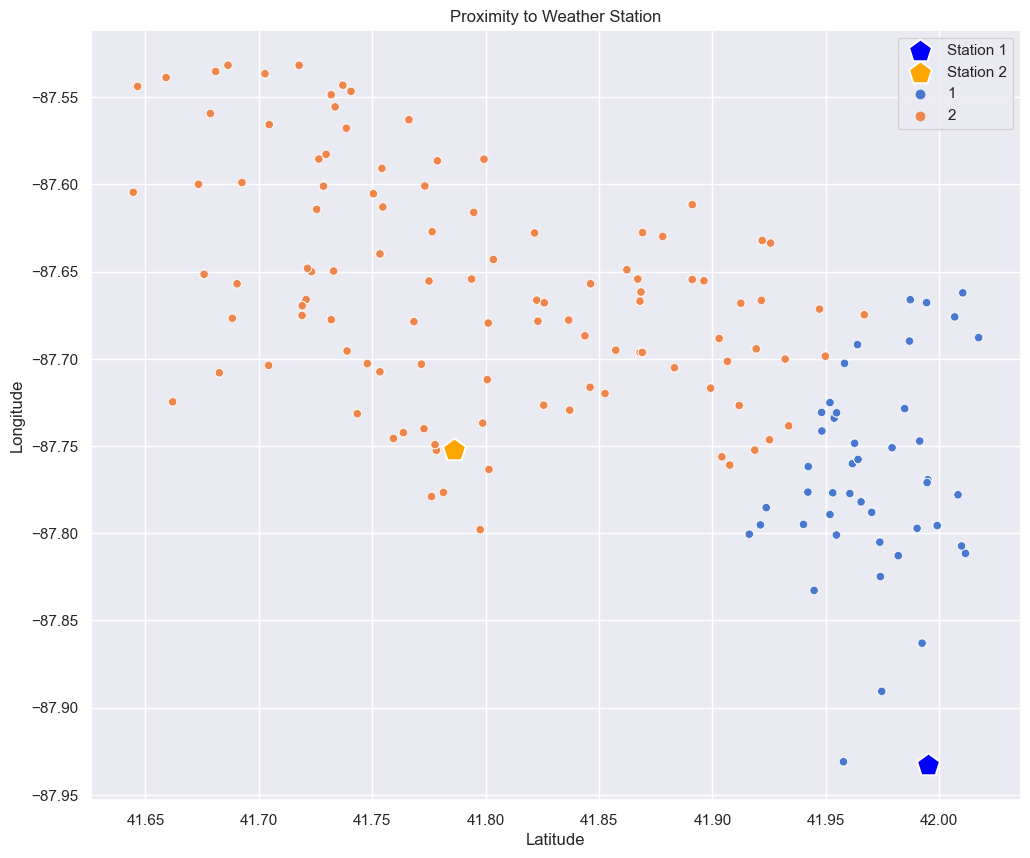

In [29]:
#visualizing the nearest assigned weather station by distance

df_station1 = pd.DataFrame({
    'Latitude': 41.995,
    'Longitude': -87.933
},
                           index=[0])
df_station2 = pd.DataFrame({
    'Latitude': 41.786,
    'Longitude': -87.752
},
                           index=[0])

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

sns.scatterplot(data=df_station1,
                x='Latitude',
                y='Longitude',
                marker="p",
                label="Station 1",
                facecolor="blue",
                s=300)
sns.scatterplot(data=df_station2,
                x='Latitude',
                y='Longitude',
                marker="p",
                label="Station 2",
                facecolor="orange",
                s=300)
sns.scatterplot(data=df_test,
                x='Latitude',
                y='Longitude',
                hue='Station',
                palette="muted").set(title='Proximity to Weather Station')
plt.legend(loc='upper right');

In [30]:
# Over here we apply transformation to the weather data, where k is the day lag for each weather feature.
# 3 kinds of transformation we will apply: shifting, rolling mean and rolling max

# features are shifted by 6 days
k1 = 6
weather_features_shift = {
    "Tmax": k1,
    "Tmin": k1,
    "Tavg": k1,
    "DewPoint": k1,
    "Sunrise": k1,
    "Sunset": k1,
    "Day_length": k1,
    "PrecipTotal": k1,
    "ResultSpeed": k1
}

# 12 days rolling mean
k2 = 12
weather_features_rollingmean = {
    "Tmax": k2,
    "Tmin": k2,
    "Tavg": k2,
    "DewPoint": k2,
    "Sunrise": k2,
    "Sunset": k2,
    "Day_length": k2,
    "PrecipTotal": k2,
    "ResultSpeed": k2
}

# 14 days rolling max
k3 = 14
weather_features_rollingMax = {
    "Tmax": k3,
    "Tmin": k3,
    "Tavg": k3,
    'DewPoint': k3,
    "Sunrise": k3,
    "Sunset": k3,
    'Day_length': k3,
    'PrecipTotal': k3,
    'ResultSpeed': k3
}

# Over here we will create the final dataset to be used in subsequent notebooks
# We will merge the transformed weather features with the original Train data
df_final = add_weather_features(df_train, weather_features_shift,
                                weather_features_rollingmean,
                                weather_features_rollingMax)

# Do the same for the Test data
df_final_submission = add_weather_features(df_test, weather_features_shift,
                                           weather_features_rollingmean,
                                           weather_features_rollingMax)

In [31]:
df_final.shape

(10506, 86)

In [32]:
df_final.head(5)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry,year,month,week,day,year_month,Station,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,trap_cluster_1,trap_cluster_2,trap_cluster_3,trap_cluster_4,trap_cluster_5,trap_cluster_6,trap_cluster_7,trap_cluster_8,trap_cluster_9,trap_cluster_10,trap_cluster_11,trap_cluster_12,trap_cluster_13,trap_cluster_14,trap_cluster_15,trap_cluster_16,trap_cluster_17,trap_cluster_18,trap_cluster_19,trap_cluster_20,trap_cluster_21,trap_cluster_22,trap_cluster_23,trap_cluster_24,trap_cluster_25,trap_cluster_26,trap_cluster_27,trap_cluster_28,trap_cluster_29,Tmax,Tmin,Tavg,DewPoint,Sunrise,Sunset,Day_length,PrecipTotal,ResultSpeed,Tmax-6,Tmin-6,Tavg-6,DewPoint-6,Sunrise-6,Sunset-6,Day_length-6,PrecipTotal-6,ResultSpeed-6,Tmax-avg-12,Tmin-avg-12,Tavg-avg-12,DewPoint-avg-12,Sunrise-avg-12,Sunset-avg-12,Day_length-avg-12,PrecipTotal-avg-12,ResultSpeed-avg-12,Tmax-max-14,Tmin-max-14,Tavg-max-14,DewPoint-max-14,Sunrise-max-14,Sunset-max-14,Day_length-max-14,PrecipTotal-max-14,ResultSpeed-max-14
id_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,60,74.00,58,421,1917,14.93,0.00,5.80,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,60,74.00,58,421,1917,14.93,0.00,5.80,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0,POINT (-87.76928 41.99499),2007,5,22,29,2007-05,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,88,60,74.00,58,421,1917,14.93,0.00,5.80,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,60,74.00,58,421,1917,14.93,0.00,5.80,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,60,74.00,58,421,1917,14.93,0.00,5.80,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90


In [33]:
df_final.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'geometry', 'year', 'month', 'week', 'day', 'year_month',
       'Station', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_OTHERS', 'trap_cluster_1', 'trap_cluster_2', 'trap_cluster_3',
       'trap_cluster_4', 'trap_cluster_5', 'trap_cluster_6', 'trap_cluster_7',
       'trap_cluster_8', 'trap_cluster_9', 'trap_cluster_10',
       'trap_cluster_11', 'trap_cluster_12', 'trap_cluster_13',
       'trap_cluster_14', 'trap_cluster_15', 'trap_cluster_16',
       'trap_cluster_17', 'trap_cluster_18', 'trap_cluster_19',
       'trap_cluster_20', 'trap_cluster_21', 'trap_cluster_22',
       'trap_cluster_23', 'trap_cluster_24', 'trap_cluster_25',
       'trap_cluster_26', 'trap_cluster_27', 'trap_cluster_28',
       'trap_cluster_29', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise',
       'Sunset', 'Da

In [34]:
#looking at the results of the transformation on Trap T002

df_weather_feat = df_final.loc[df_final['Trap'] == 'T002']
df_weather_feat = df_weather_feat[[
    'Date', 'Trap', 'Tmax-6', 'Tmin-6', 'Tavg-6', 'DewPoint-6', 'Sunrise-6',
    'Sunset-6', 'Day_length-6', 'PrecipTotal-6', 'ResultSpeed-6',
    'Tmax-avg-12', 'Tmin-avg-12', 'Tavg-avg-12', 'DewPoint-avg-12',
    'Sunrise-avg-12', 'Sunset-avg-12', 'Day_length-avg-12',
    'PrecipTotal-avg-12', 'ResultSpeed-avg-12', 'Tmax-max-14', 'Tmin-max-14',
    'Tavg-max-14', 'DewPoint-max-14', 'Sunrise-max-14', 'Sunset-max-14',
    'Day_length-max-14', 'PrecipTotal-max-14', 'ResultSpeed-max-14'
]]

df_weather_feat.head(10)

,Date,Trap,Tmax-6,Tmin-6,Tavg-6,DewPoint-6,Sunrise-6,Sunset-6,Day_length-6,PrecipTotal-6,ResultSpeed-6,Tmax-avg-12,Tmin-avg-12,Tavg-avg-12,DewPoint-avg-12,Sunrise-avg-12,Sunset-avg-12,Day_length-avg-12,PrecipTotal-avg-12,ResultSpeed-avg-12,Tmax-max-14,Tmin-max-14,Tavg-max-14,DewPoint-max-14,Sunrise-max-14,Sunset-max-14,Day_length-max-14,PrecipTotal-max-14,ResultSpeed-max-14
id_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2007-05-29,T002,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
1,2007-05-29,T002,89.00,60.00,75.00,49.00,425.00,"1,912.00",14.78,0.00,11.40,78.42,52.92,65.83,46.58,424.42,"1,912.33",14.80,0.10,8.06,89.00,63.00,76.00,58.00,431.00,"1,917.00",14.93,1.01,14.90
25,2007-06-05,T002,87.00,66.00,77.00,58.00,420.00,"1,918.00",14.97,0.00,10.30,76.75,58.08,67.67,55.17,420.00,"1,918.42",14.97,0.18,6.31,89.00,66.00,77.00,63.00,425.00,"1,923.00",15.10,1.01,14.90
26,2007-06-05,T002,87.00,66.00,77.00,58.00,420.00,"1,918.00",14.97,0.00,10.30,76.75,58.08,67.67,55.17,420.00,"1,918.42",14.97,0.18,6.31,89.00,66.00,77.00,63.00,425.00,"1,923.00",15.10,1.01,14.90
27,2007-06-05,T002,87.00,66.00,77.00,58.00,420.00,"1,918.00",14.97,0.00,10.30,76.75,58.08,67.67,55.17,420.00,"1,918.42",14.97,0.18,6.31,89.00,66.00,77.00,63.00,425.00,"1,923.00",15.10,1.01,14.90
85,2007-06-26,T002,84.00,61.00,73.00,52.00,416.00,"1,930.00",15.23,0.00,7.80,83.83,64.67,74.50,59.00,416.50,"1,930.00",15.22,0.09,6.67,93.00,70.00,81.00,69.00,418.00,"1,931.00",15.23,0.58,14.00
86,2007-06-26,T002,84.00,61.00,73.00,52.00,416.00,"1,930.00",15.23,0.00,7.80,83.83,64.67,74.50,59.00,416.50,"1,930.00",15.22,0.09,6.67,93.00,70.00,81.00,69.00,418.00,"1,931.00",15.23,0.58,14.00
87,2007-06-26,T002,84.00,61.00,73.00,52.00,416.00,"1,930.00",15.23,0.00,7.80,83.83,64.67,74.50,59.00,416.50,"1,930.00",15.22,0.09,6.67,93.00,70.00,81.00,69.00,418.00,"1,931.00",15.23,0.58,14.00
155,2007-06-29,T002,67.00,62.00,65.00,58.00,417.00,"1,931.00",15.23,0.05,7.60,80.50,63.50,72.17,59.00,417.17,"1,930.58",15.22,0.10,7.95,93.00,71.00,81.00,70.00,419.00,"1,931.00",15.23,0.58,14.00


In [35]:
# one final check to see that the data is clean
df_final.isnull().sum()

Date                              0
Address                           0
Block                             0
Street                            0
Trap                              0
AddressNumberAndStreet            0
Latitude                          0
Longitude                         0
AddressAccuracy                   0
NumMosquitos                      0
WnvPresent                        0
geometry                          0
year                              0
month                             0
week                              0
day                               0
year_month                        0
Station                           0
Species_CULEX PIPIENS/RESTUANS    0
Species_CULEX RESTUANS            0
Species_OTHERS                    0
trap_cluster_1                    0
trap_cluster_2                    0
trap_cluster_3                    0
trap_cluster_4                    0
trap_cluster_5                    0
trap_cluster_6                    0
trap_cluster_7              

## Pickle data
*Back to [Contents](#Contents:)*

In [36]:
# Save neccessary object to pickle_dict, which will be pickled in next notebook for modeling
pickle_dict2 = dict()
pickle_dict2['df_train']=df_train
pickle_dict2['df_test']=df_test
pickle_dict2['df_final']=df_final
pickle_dict2['df_final_submission']=df_final_submission
pickle.dump(pickle_dict2, open('../assets/data2.pkl', 'wb'))